In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import vaex

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, save_model_params_to_json, load_model_params_from_json
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/'

# Data

In [2]:
%%time

filename = "../../../models/2020/boat_data_50ms.csv"
rename_columns = {
    'Solar POA': 'pv_g',
    **{f'MPPT {i} Duty Cycle': f'mppt_{i}_d' for i in range(1,5)},
    **{f'MPPT {i} Input Current': f'mppt_{i}_i_in' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt_{i}_v_in' for i in range(1,5)},
    **{f'MPPT {i} Output Voltage': f'mppt_{i}_v_out' for i in range(1,5)},
}

df = vaex.from_csv(filename)[["timestamp", *rename_columns.keys()]].to_pandas_df().rename(columns=rename_columns)
df["timestamp"] = pd.DatetimeIndex(df["timestamp"])
df = df.set_index("timestamp", drop=True)
df = df.interpolate(method='time', limit=50, limit_area='inside')
df = df.resample('5min').mean()
df["mppt_d"]     = df[[f"mppt_{i}_d"     for i in range(1, 5)]].mean(axis=1)
df["mppt_i_in"]  = df[[f"mppt_{i}_i_in"  for i in range(1, 5)]].mean(axis=1)
df["mppt_v_in"]  = df[[f"mppt_{i}_v_in"  for i in range(1, 5)]].mean(axis=1)
df["mppt_v_out"] = df[[f"mppt_{i}_v_out" for i in range(1, 5)]].mean(axis=1)
df["t"] = df.index.to_series().diff().median().total_seconds() * np.arange(len(df.index))
df = df[["t", "pv_g", "mppt_d", "mppt_i_in", "mppt_v_in", "mppt_v_out"]]
display(df.describe())

,t,pv_g,mppt_d,mppt_i_in,mppt_v_in,mppt_v_out
count,1171.000000,1170.000000,422.000000,341.000000,342.000000,342.000000
mean,175500.000000,220.455190,0.565336,3.502842,24.643177,39.293294
std,101454.866813,303.104617,0.103006,2.837130,7.906270,3.255775
min,0.000000,0.000000,0.040000,0.000093,0.185451,29.848365
25%,87750.000000,0.000000,0.574876,1.269069,25.748437,37.702673
50%,175500.000000,46.250375,0.591750,2.397243,27.290994,38.855047
75%,263250.000000,391.343566,0.609744,6.032250,28.244394,40.012164
max,351000.000000,1021.013360,0.695167,9.965513,33.197893,48.294162


CPU times: user 23.7 s, sys: 6 s, total: 29.7 s
Wall time: 27.7 s


Train size ≃ 30.00%
Test size ≃ 70.00%


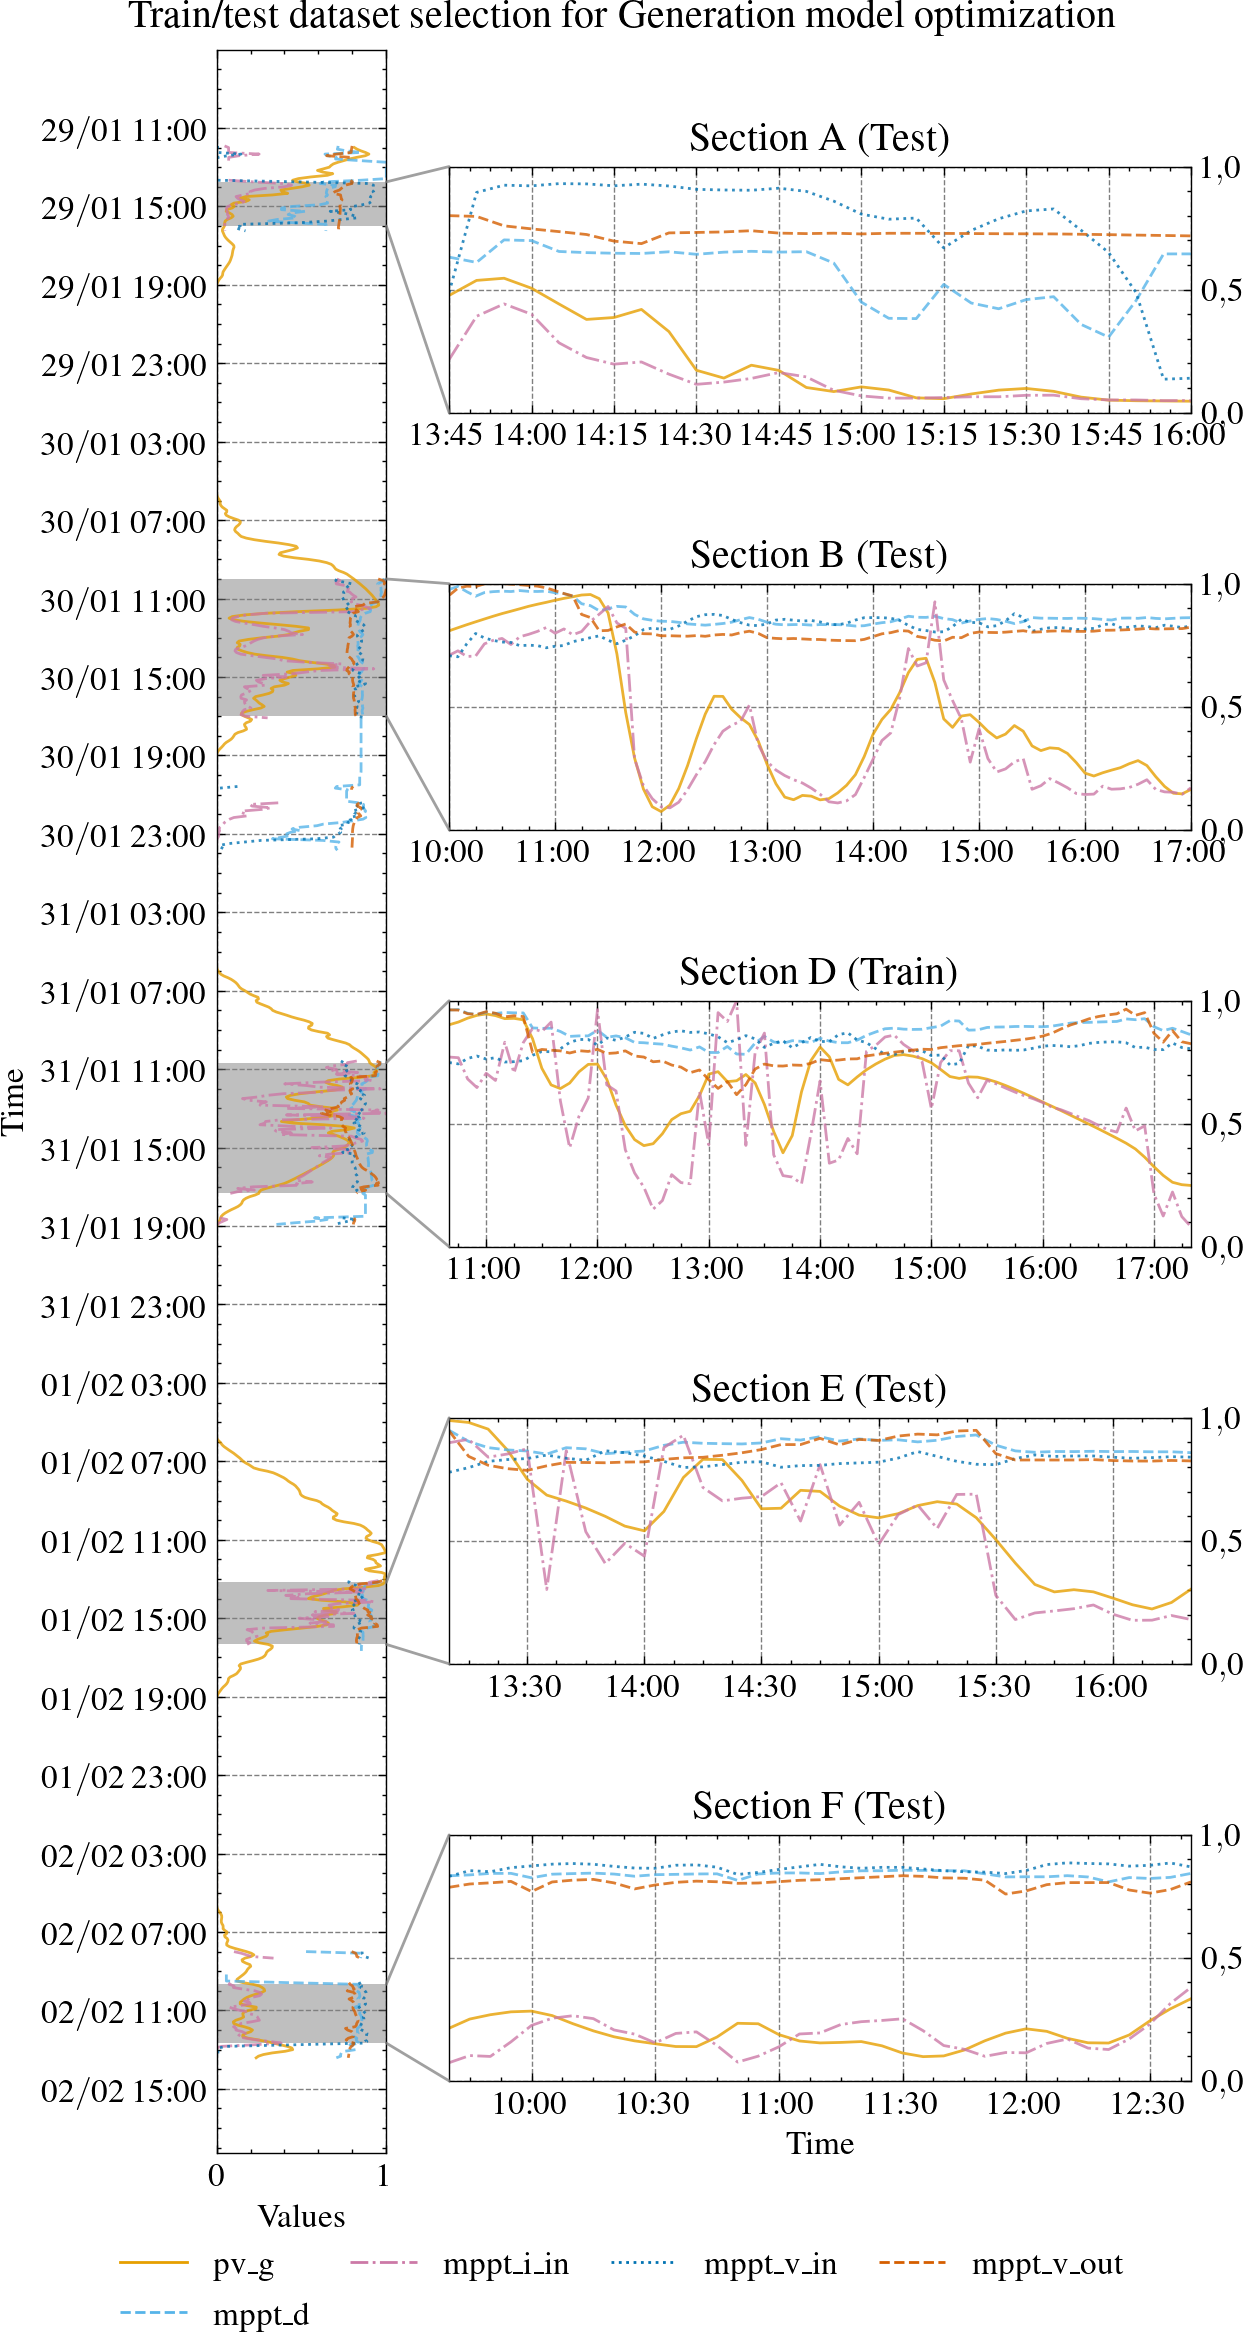

In [3]:
sections, tzinfo = get_sections()
train_section_name = 'Section D'
sections = sections.drop('Section C')
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/generation_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['pv_g', 'mppt_d', 'mppt_i_in', 'mppt_v_in', 'mppt_v_out'],
            normalize=True,
        )
    )


# Generation System model

In [4]:
from model import Generation

generation_params = {
    'pv_S': 1.650 * 0.992,
    'pv_eta': 0.1588,
    'mppt_eta': 0.9259,
    'mppts_n': 4,
}

# Model
generation = Generation.build(generation_params)
display(generation)

<NonlinearIOSystem generation: ['pv_g', 'mppt_v_out', 'mppt_d'] -> ['mppt_i_out', 'mppt_i_in', 'mppt_v_in']>

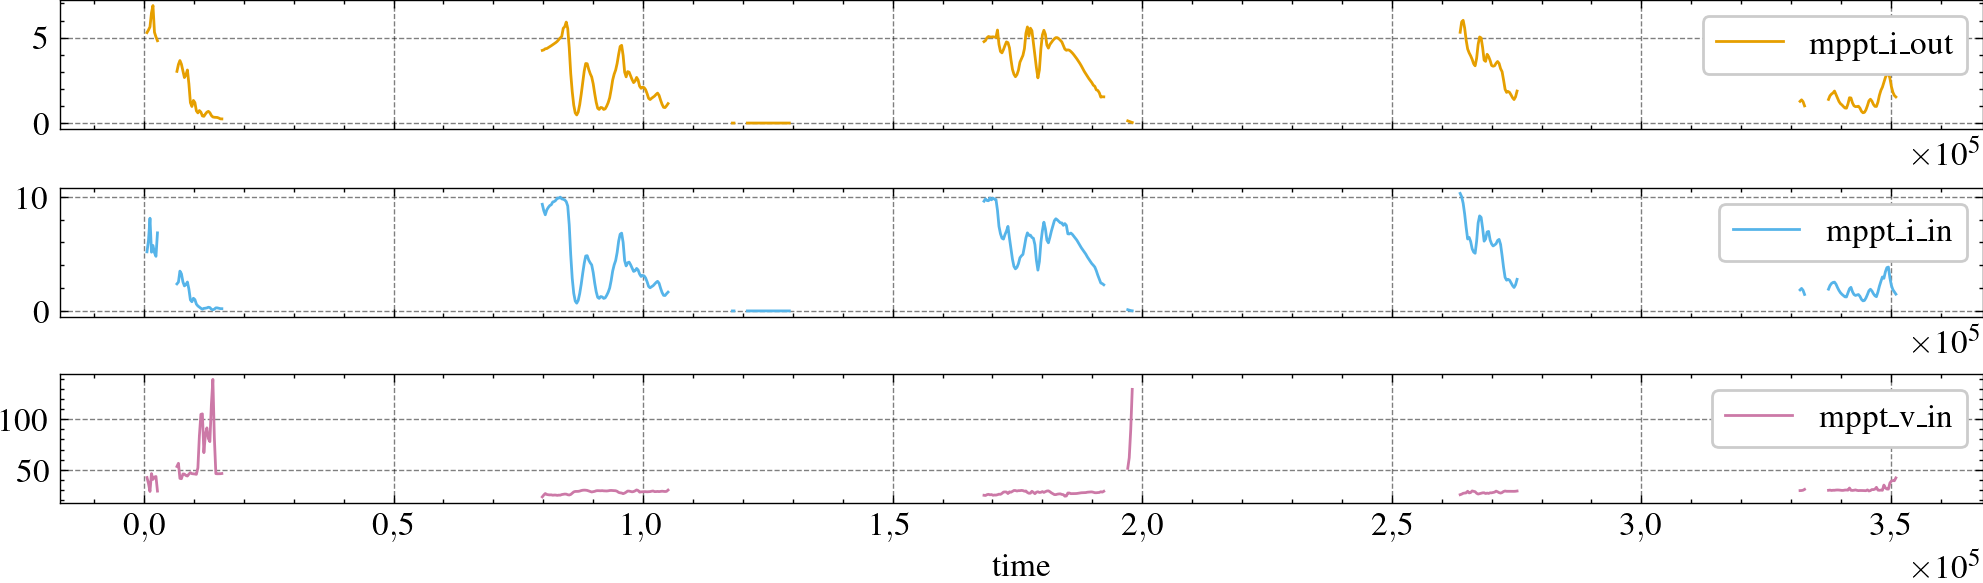

In [5]:
# Time array
T = df["t"].to_numpy()

# Inputs
U = df[['pv_g', 'mppt_v_out', 'mppt_d']].to_numpy().T

# Initial state
X0 = np.zeros(generation.nstates)
# X0[generation.state_index['']] = 1

# Simulation
res = ct.input_output_response(generation, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,3))
plt.show()

# Optimization

In [6]:
from sklearn.preprocessing import RobustScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Generation.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       80 |  4.9136291329 |  0.1805807348
     2 |      160 |  1.6101273805 |  0.1517388178
     3 |      240 |  0.7221053829 |  0.1490155037
     4 |      320 |  0.3264131437 |  0.1490155037
     5 |      400 |  0.2285257077 |  0.1490155037
     6 |      480 |  0.1842056256 |  0.1490155037
     7 |      560 |  0.1639931303 |  0.1487747106
     8 |      640 |  0.1567920029 |  0.1487747106
     9 |      720 |  0.1526457198 |  0.1485207875
    10 |      800 |  0.1510077852 |  0.1483815304
    11 |      880 |  0.1498428113 |  0.1483815304
    12 |      960 |  0.1491092117 |  0.1483815304
    13 |     1040 |  0.1488614429 |  0.1483815304
    14 |     1120 |  0.1486597965 |  0.1483815304
    15 |     1200 |  0.1485084111 |  0.1483815304
    16 |     1280 |  0.1484478074 |  0.1483815304
    17 |     1360 |  0.1484104637 |  0.1483815304
    18 |     1440 |  0.1483960527 |  0.1483815304
    19 |     1520 |  0.1483909854 |  0.1483815304


{'pv_eta': 0.1588, 'mppt_eta': 0.9259}

Best parameters found:


{'pv_eta': 0.14309907292684962, 'mppt_eta': 0.9323459474182263}

Objective value at solution: [0.1483815]


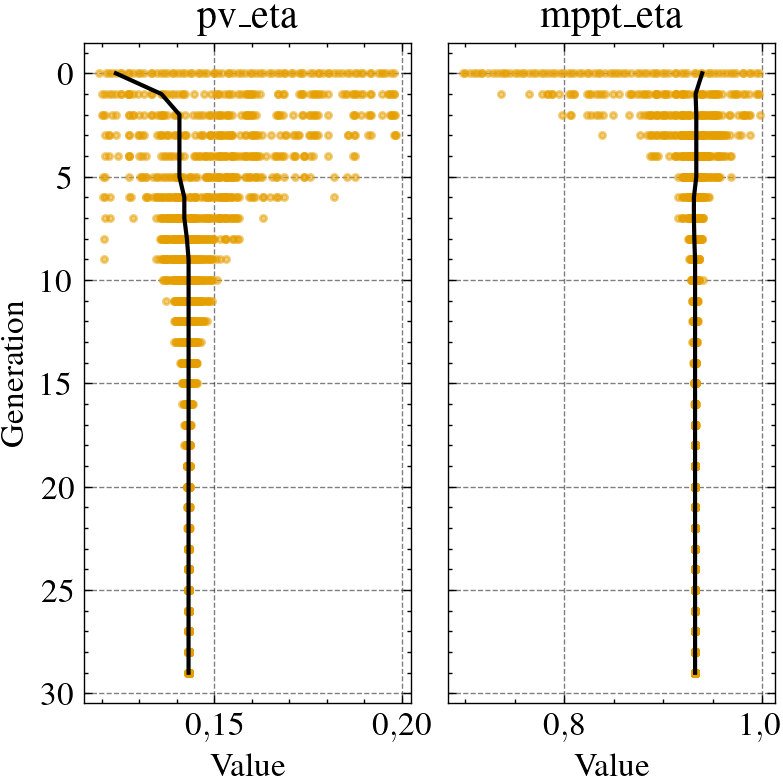

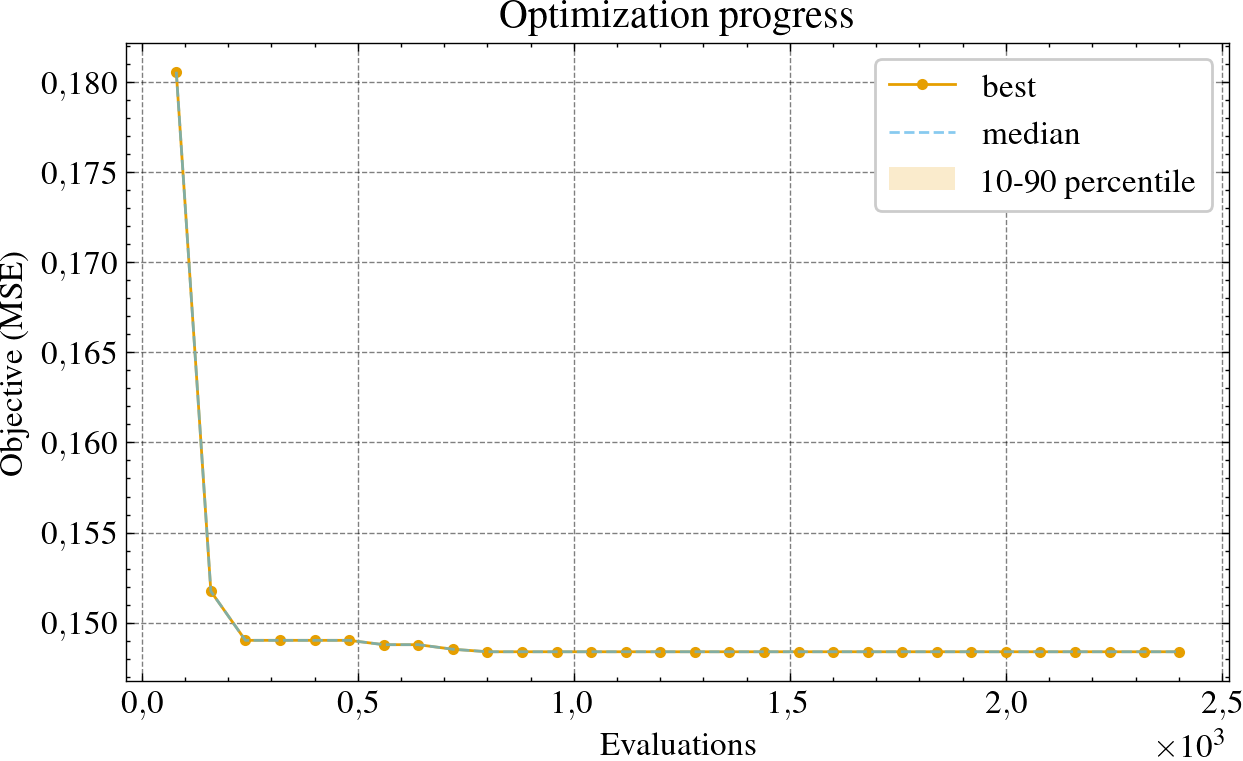

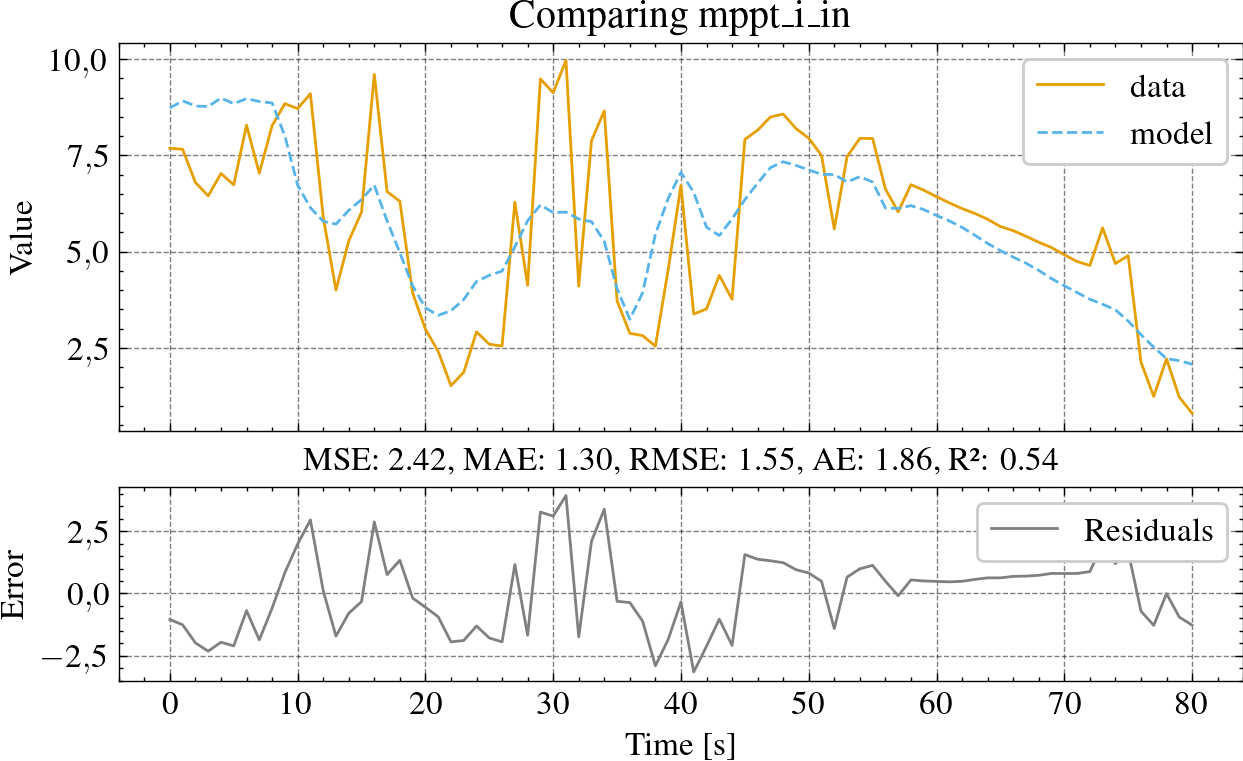

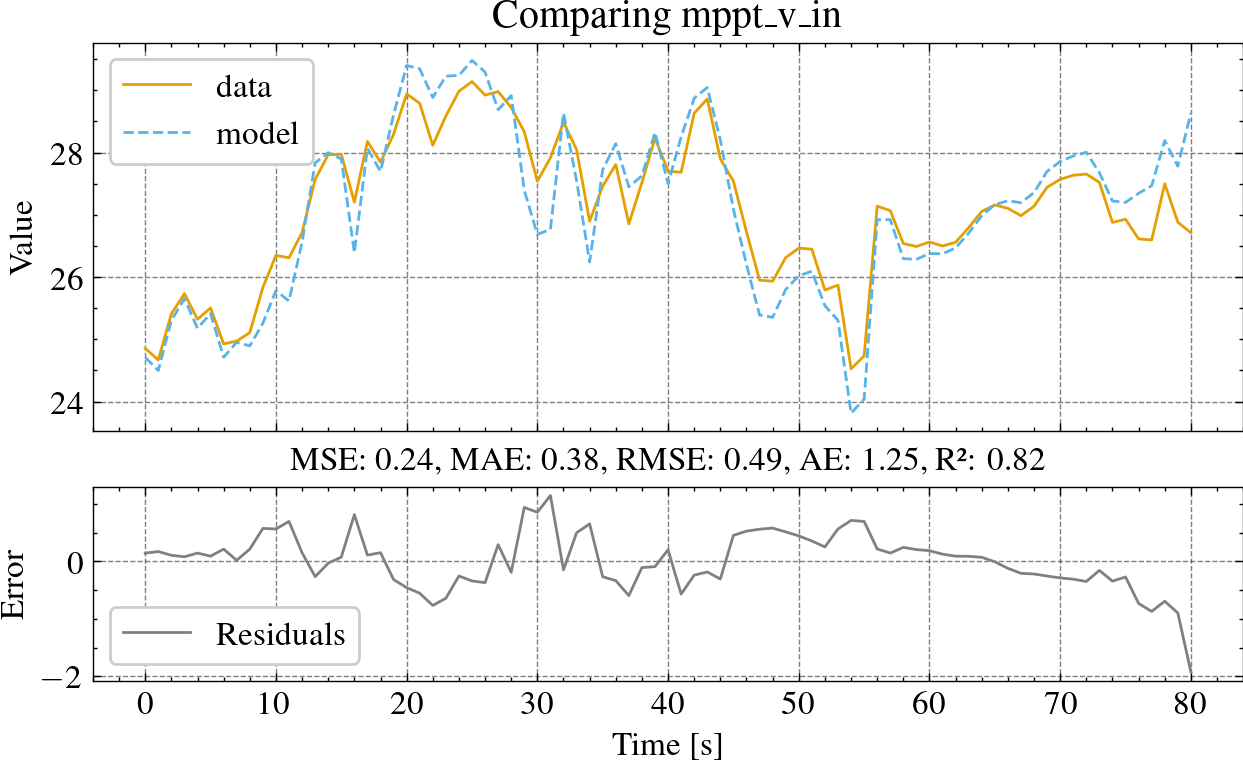

CPU times: user 1.62 s, sys: 3.46 s, total: 5.08 s
Wall time: 2.72 s


In [7]:
%%time
## GENERATION OPTIMIZATION

# Select the optimization data
data_cols = ['mppt_i_in', 'mppt_v_in']
input_cols = ['pv_g', 'mppt_v_out', 'mppt_d']

# Put simulation data into df
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]

# Set model states initial conditions
input_initial_state = {}

# Initialize Parameters
variation = 25/100
model_params = generation_params
params_bounds = {
    'pv_eta': dict(min=max(0, model_params['pv_eta']*(1-variation)), max=min(1, model_params['pv_eta']*(1+variation))),
    'mppt_eta': dict(min=max(0, model_params['mppt_eta']*(1-variation)), max=min(1, model_params['mppt_eta']*(1+variation))),
}

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)
try:
    # Initialize the problem
    model = Generation
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=RobustScaler,
        elementwise_runner=runner,
        print_exceptions=True,
    )

    algorithm = DE(
        pop_size=40*len(params_bounds),
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.2,
        CR=0.9,
        dither='array'
    )

    # Specify termination criteria (optional)
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=1000,
        n_max_evals=100000
    )

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )
    print('Threads:', result.exec_time)
finally:
    pool.close()
    pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)


In [8]:
params_output_path = 'generation_params.json'
save_model_params_to_json(params_output_path, generation_params | best_params)
model_params = load_model_params_from_json(params_output_path)
model_params


{'mppt_eta': 0.9323459474182263,
 'mppts_n': 4,
 'pv_S': 1.6367999999999998,
 'pv_eta': 0.14309907292684962}

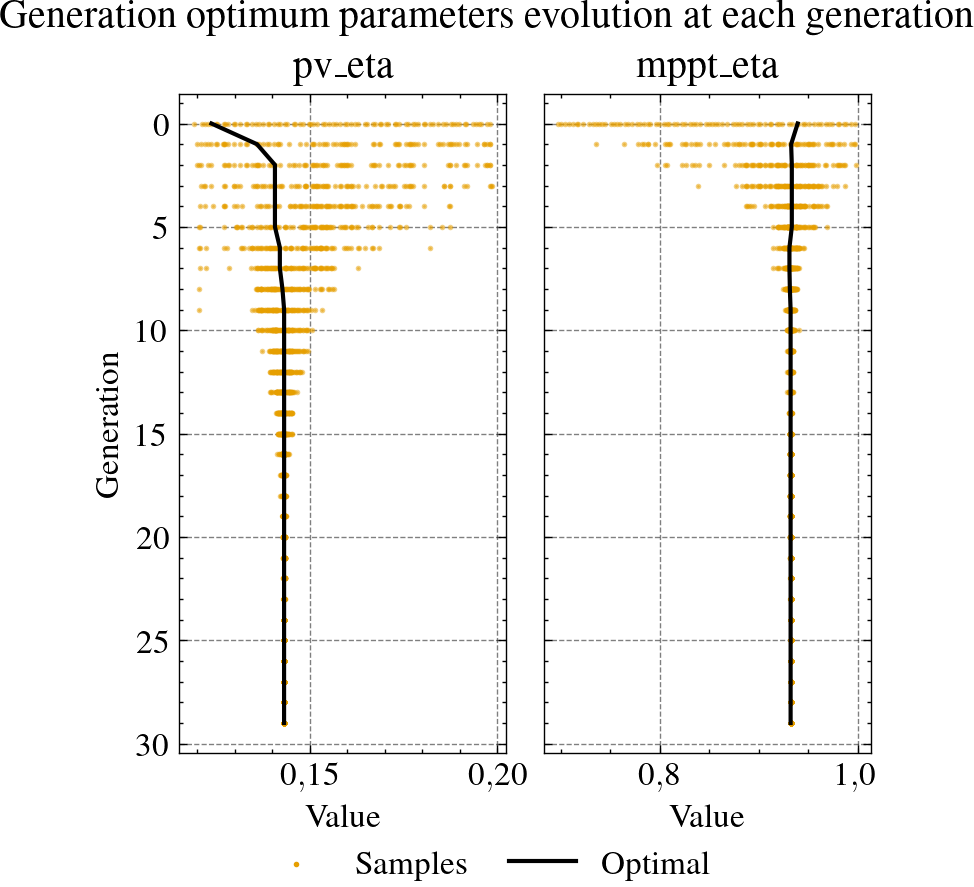

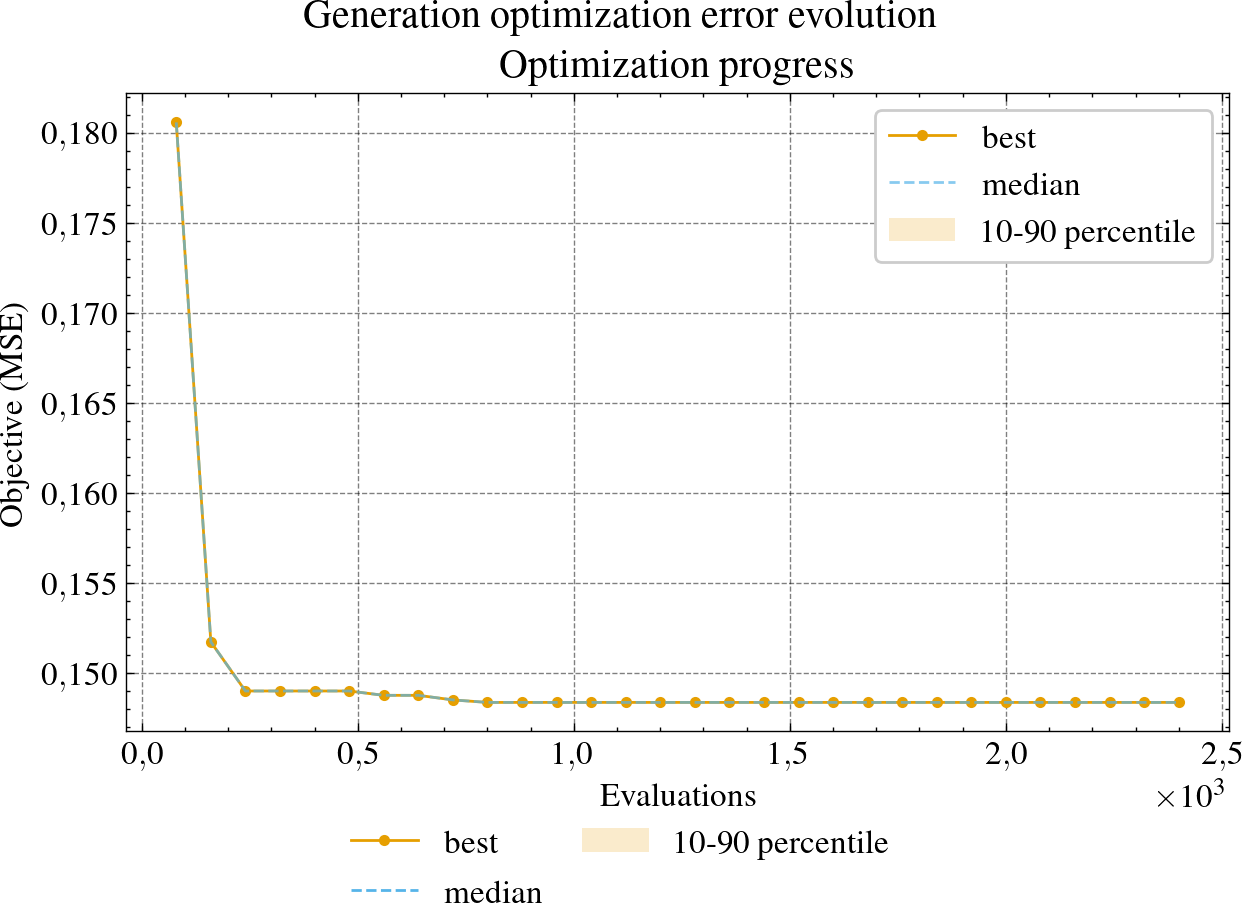

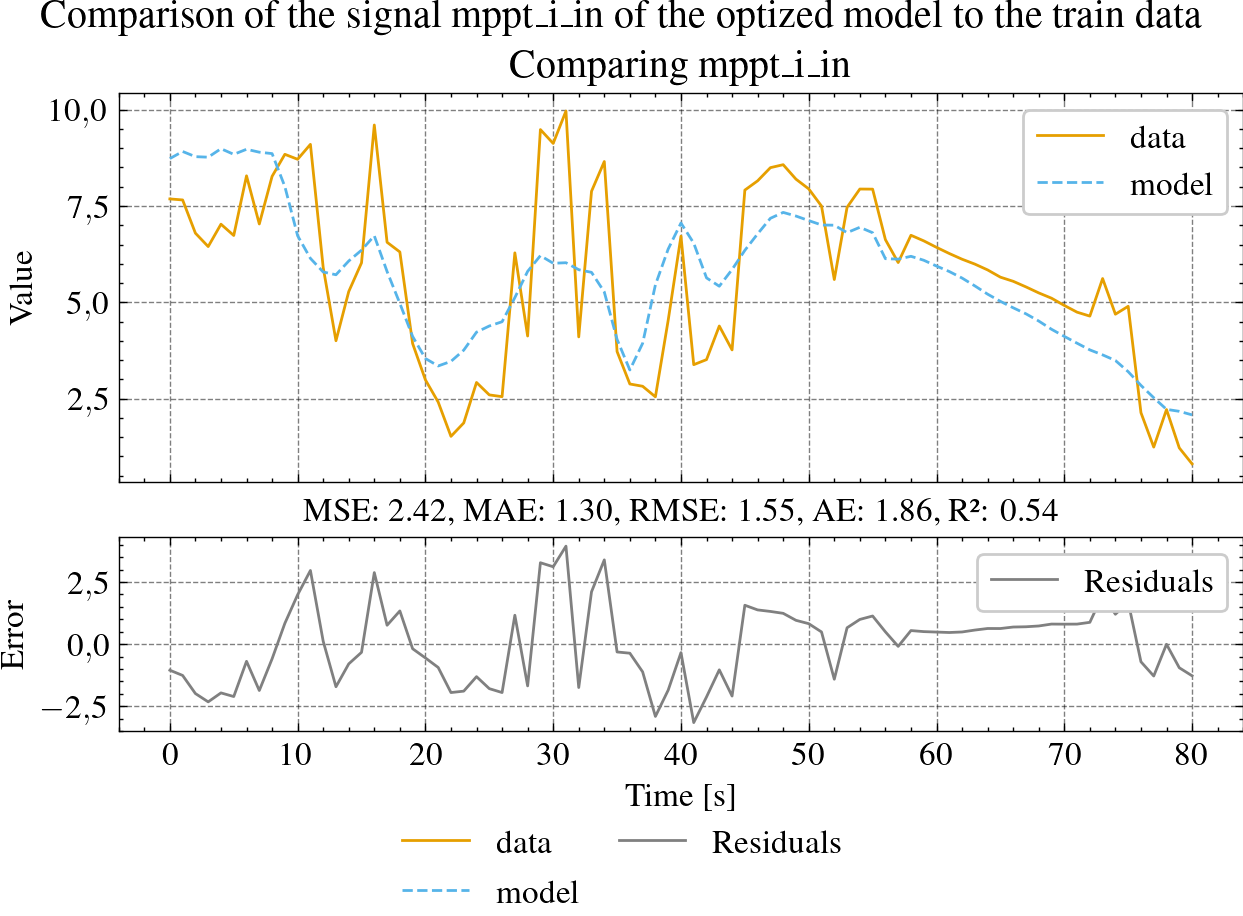

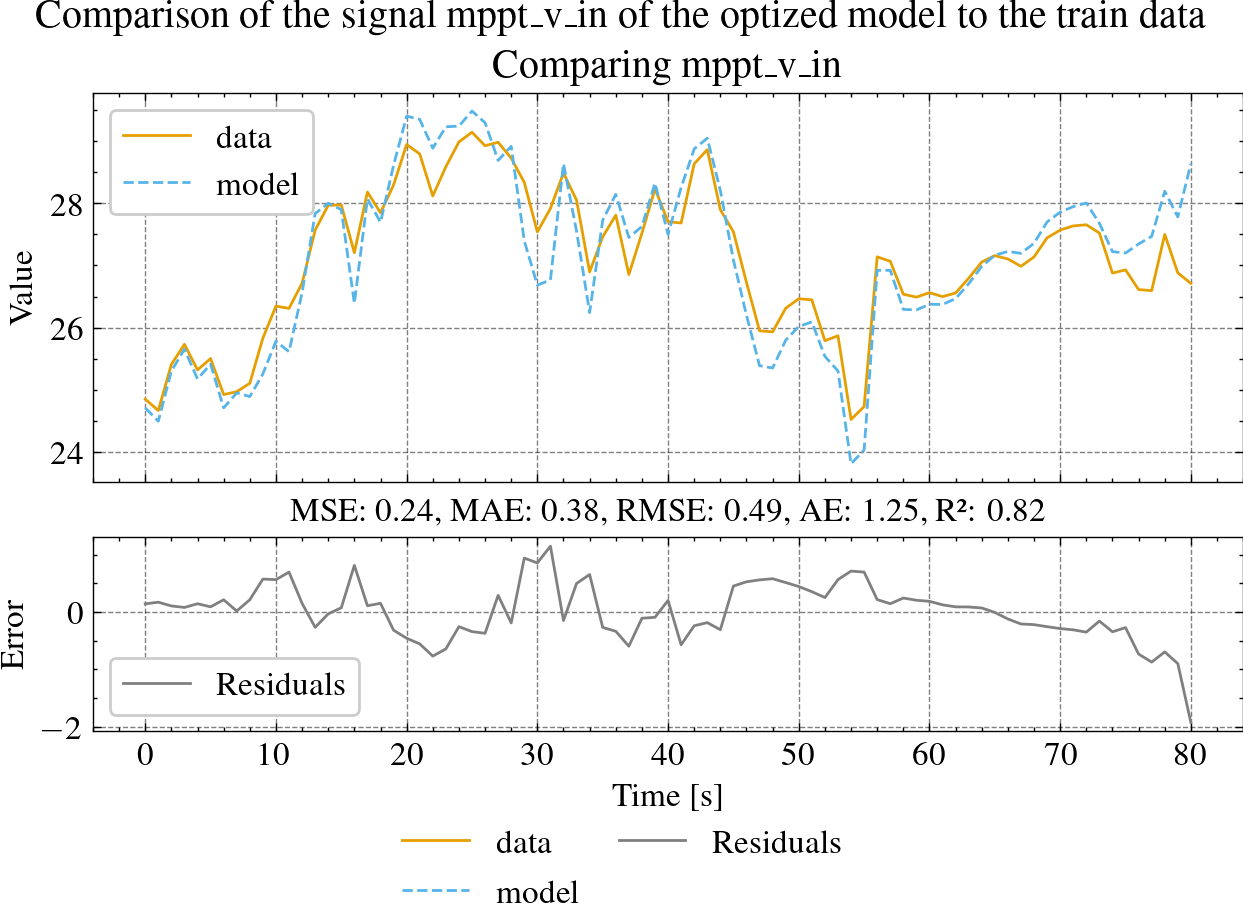

In [9]:
# Plot the original data and the fitted curve
fig_save_and_show(
    filename=f'{latex_img_path}/generation_optimization_params.pdf',
    show_title='Generation optimum parameters evolution at each generation',
    save_title='Evolução dos parâmetros ótimos do modelo PVs+MPPTs à cada geração',
    ncol=2,
    fig=plot_optimization_params(result, params_bounds=params_bounds, scatter_alpha=0.5, scatter_size=1, show=False)
)

fig_save_and_show(
    filename=f'{latex_img_path}/generation_optimization_error.pdf',
    show_title='Generation optimization error evolution',
    save_title='Evolução do erro de otimização do modelo da Geração',
    ncol=2,
    fig=plot_optimization_error(result, show=False),
)

for col in data_cols:
    fig_save_and_show(
        filename=f'{latex_img_path}/generation_optimization_residuals_{col}_train.pdf',
        show_title=f'Comparison of the signal {col} of the optized model to the train data',
        save_title=f'Comparação do sinal {col} do modelo otimizado com os dados de treino',
        ncol=2,
        fig=plot_compare(df_train, best_fit_data, col, show=False),
    )

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_i_in_test_a.pdf


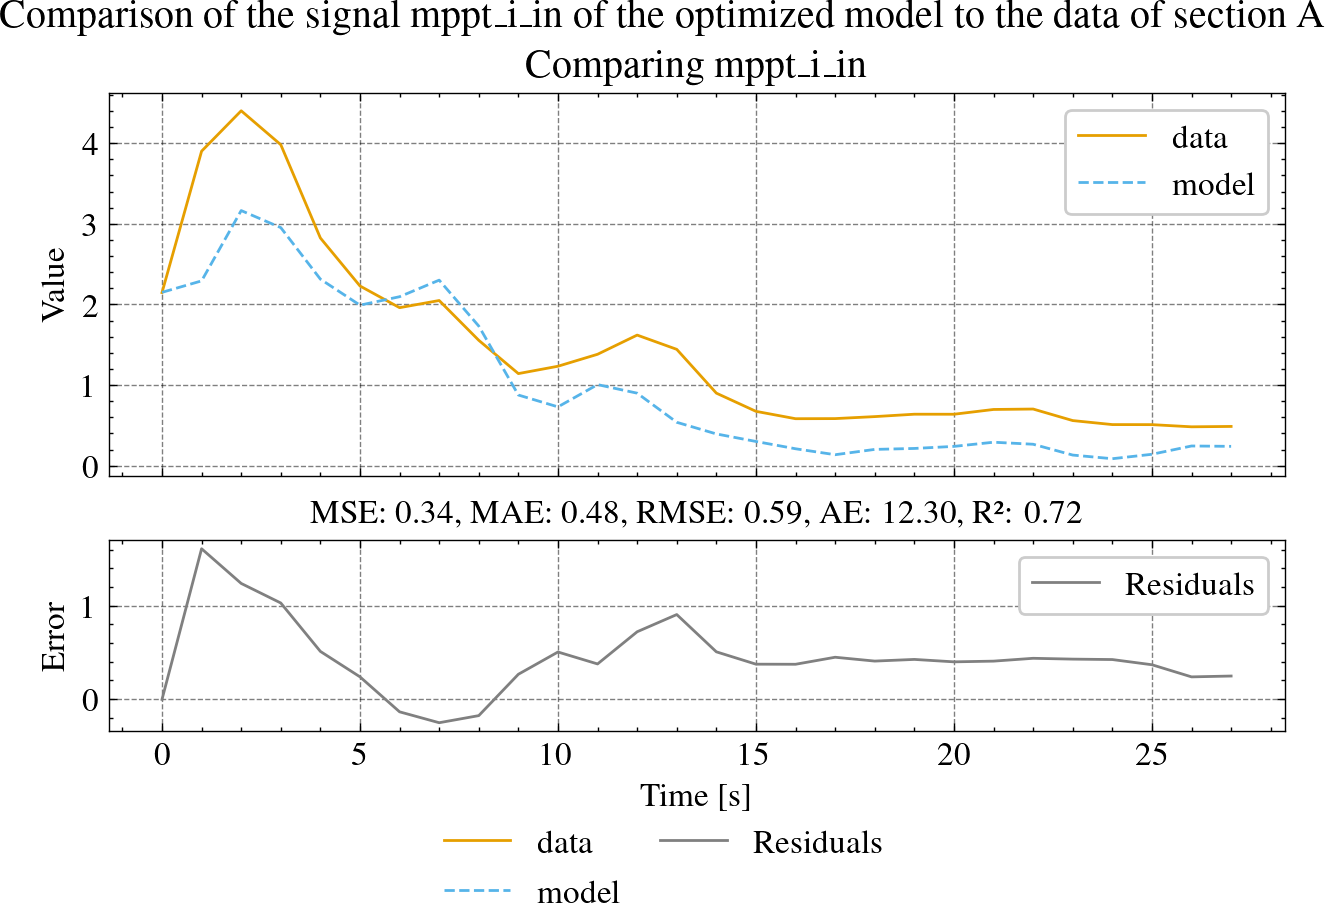

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_v_in_test_a.pdf


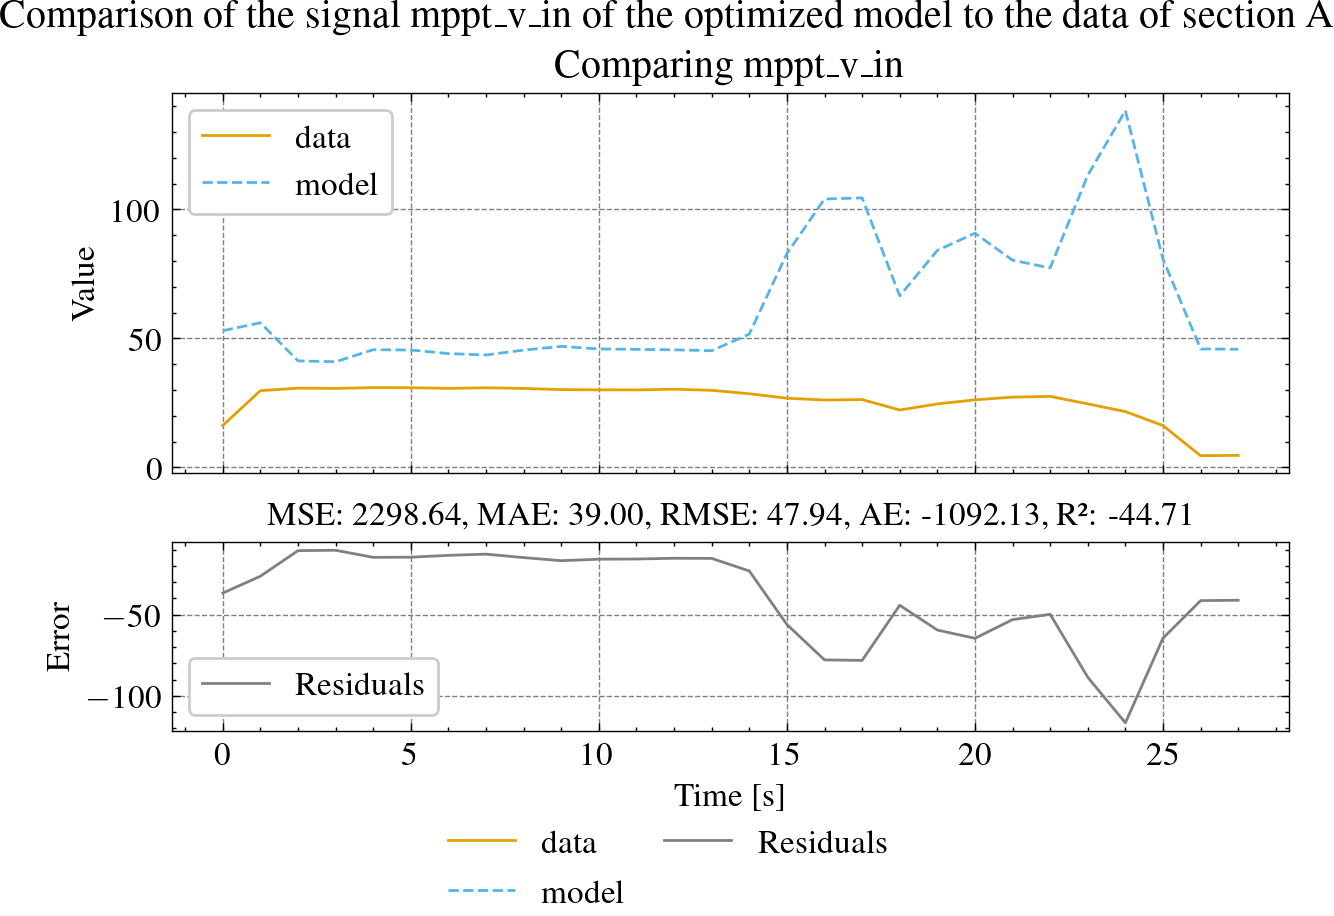

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_i_in_test_b.pdf


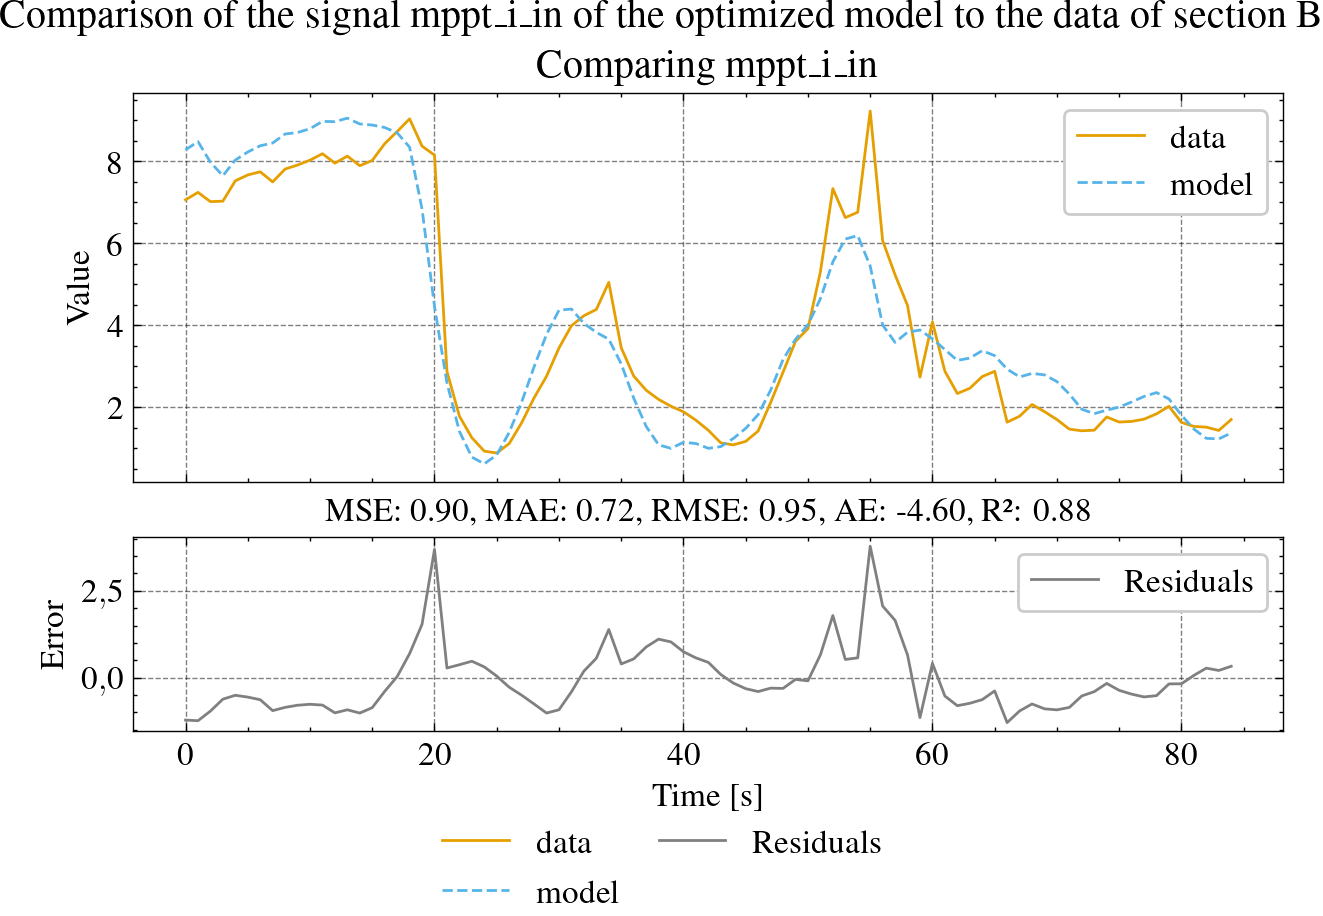

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_v_in_test_b.pdf


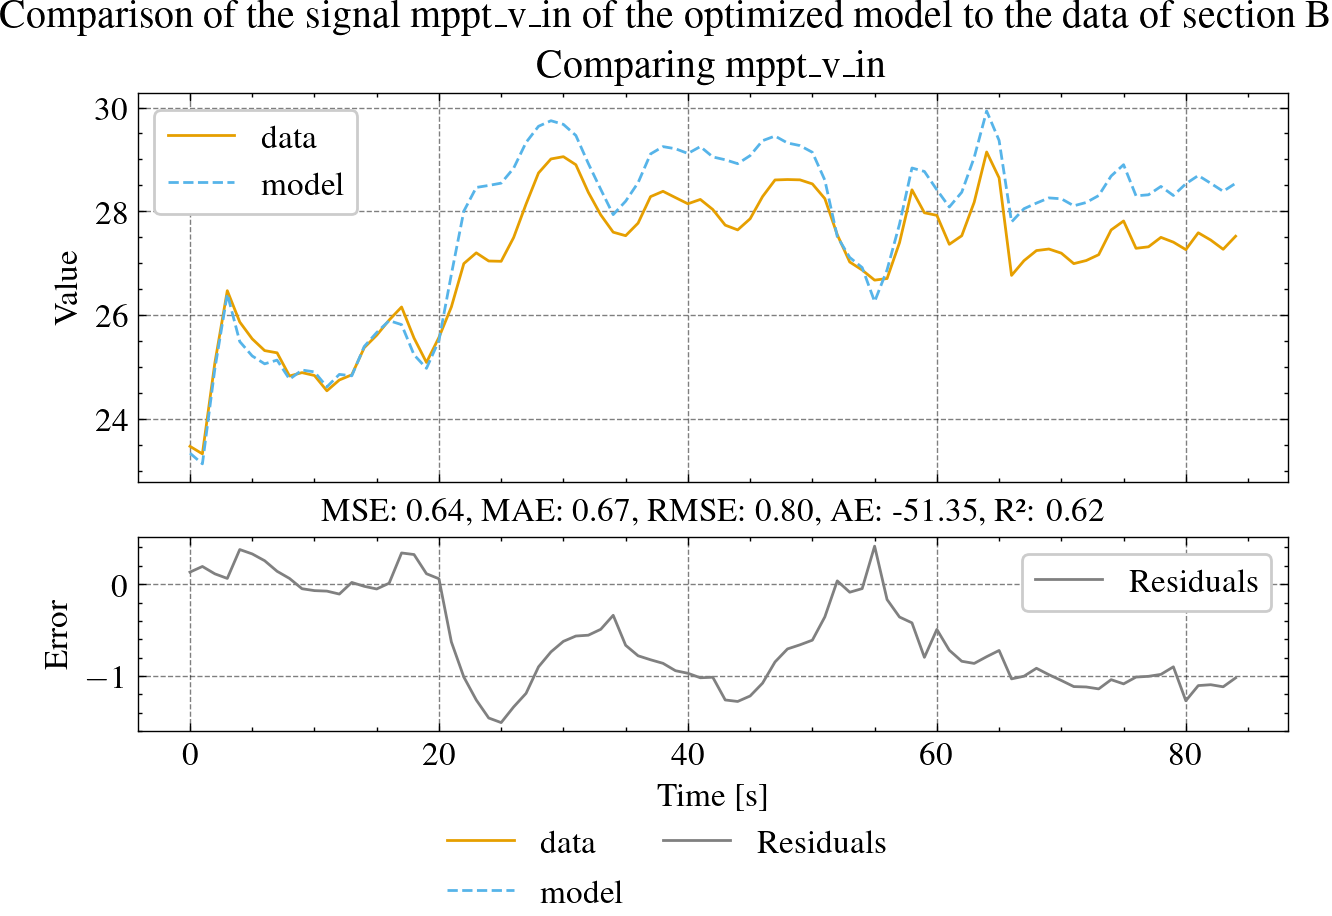

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_i_in_test_d.pdf


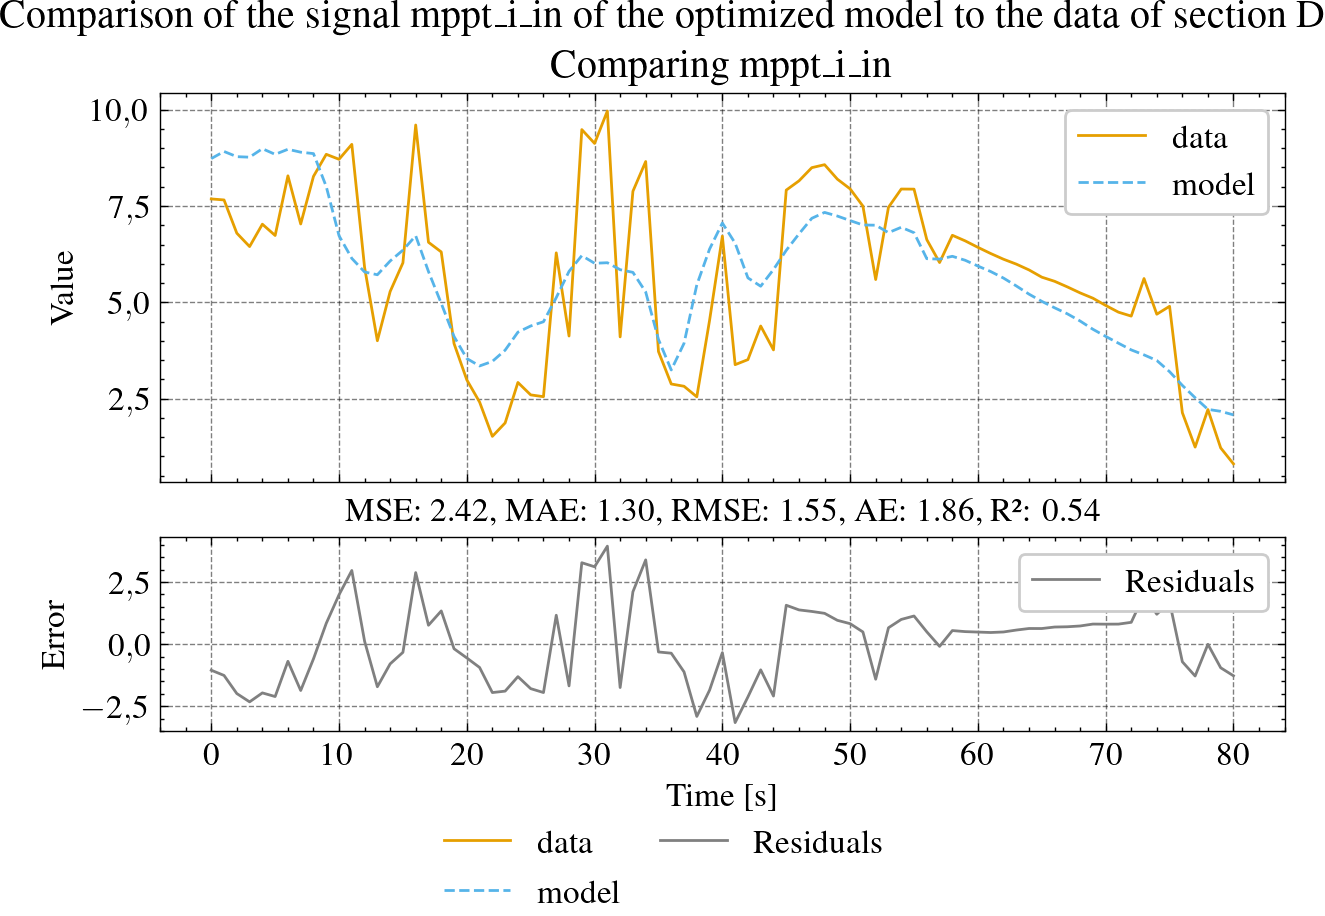

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_v_in_test_d.pdf


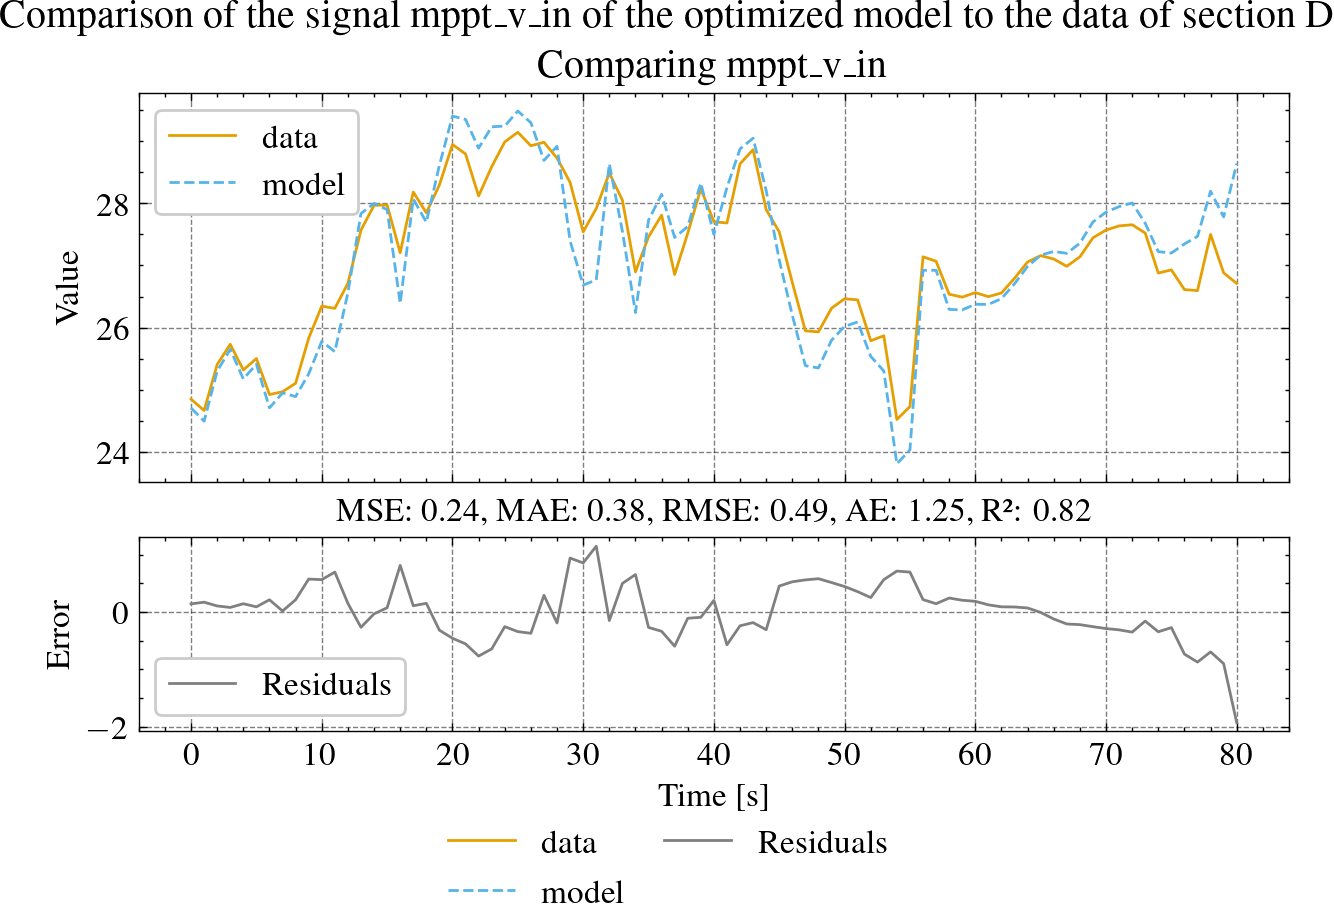

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_i_in_test_e.pdf


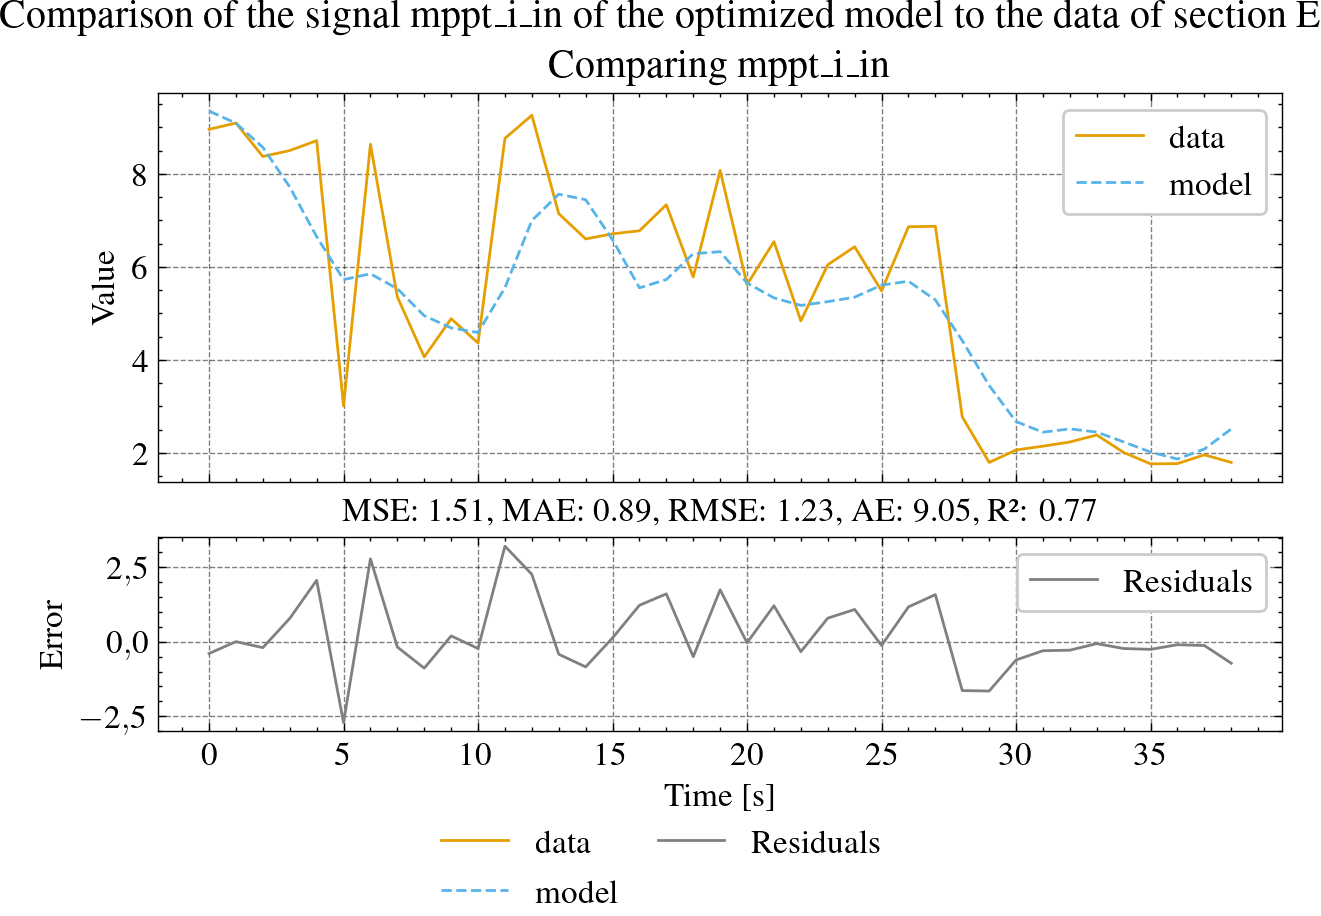

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_v_in_test_e.pdf


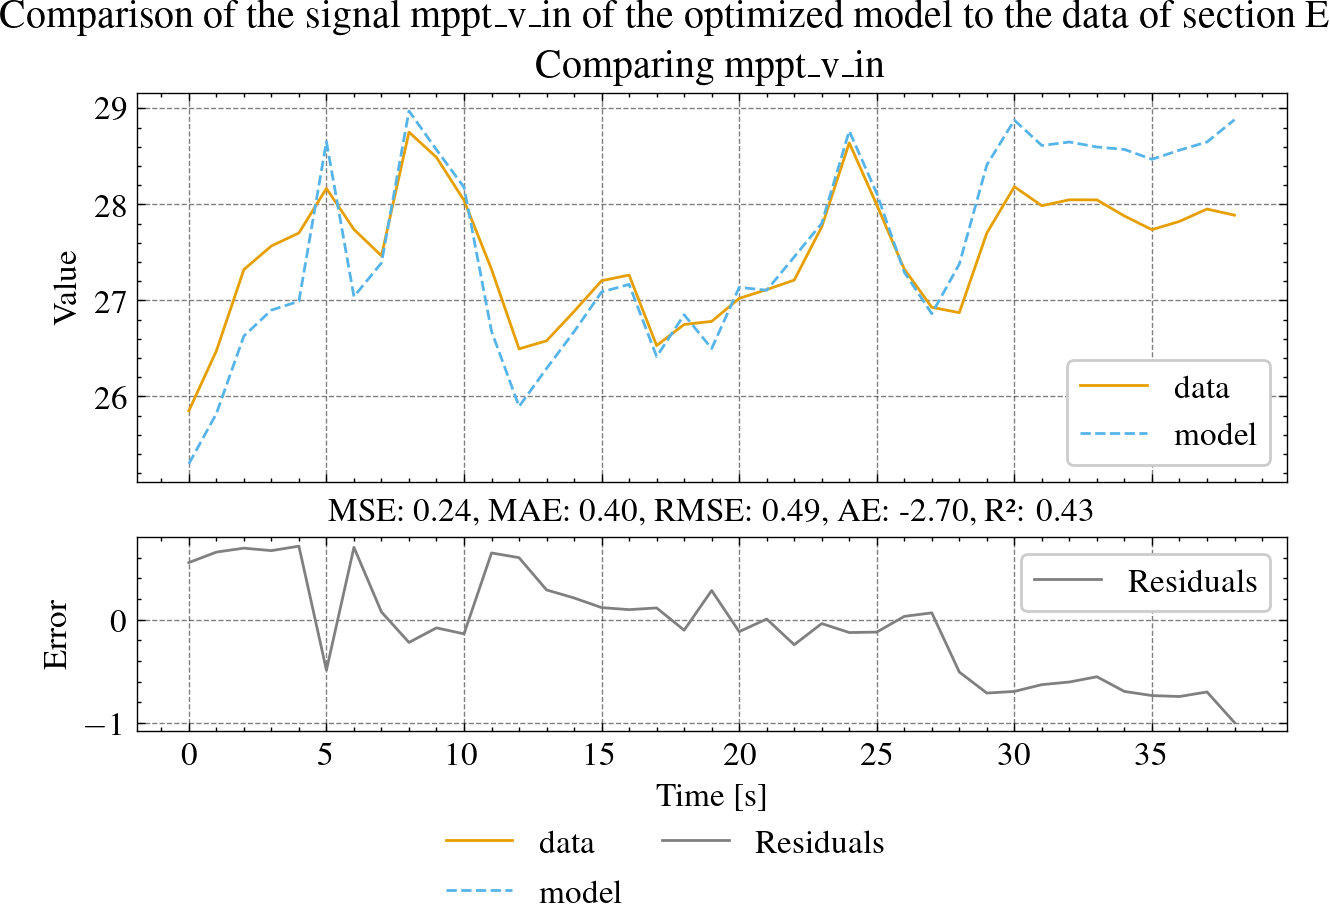

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_i_in_test_f.pdf


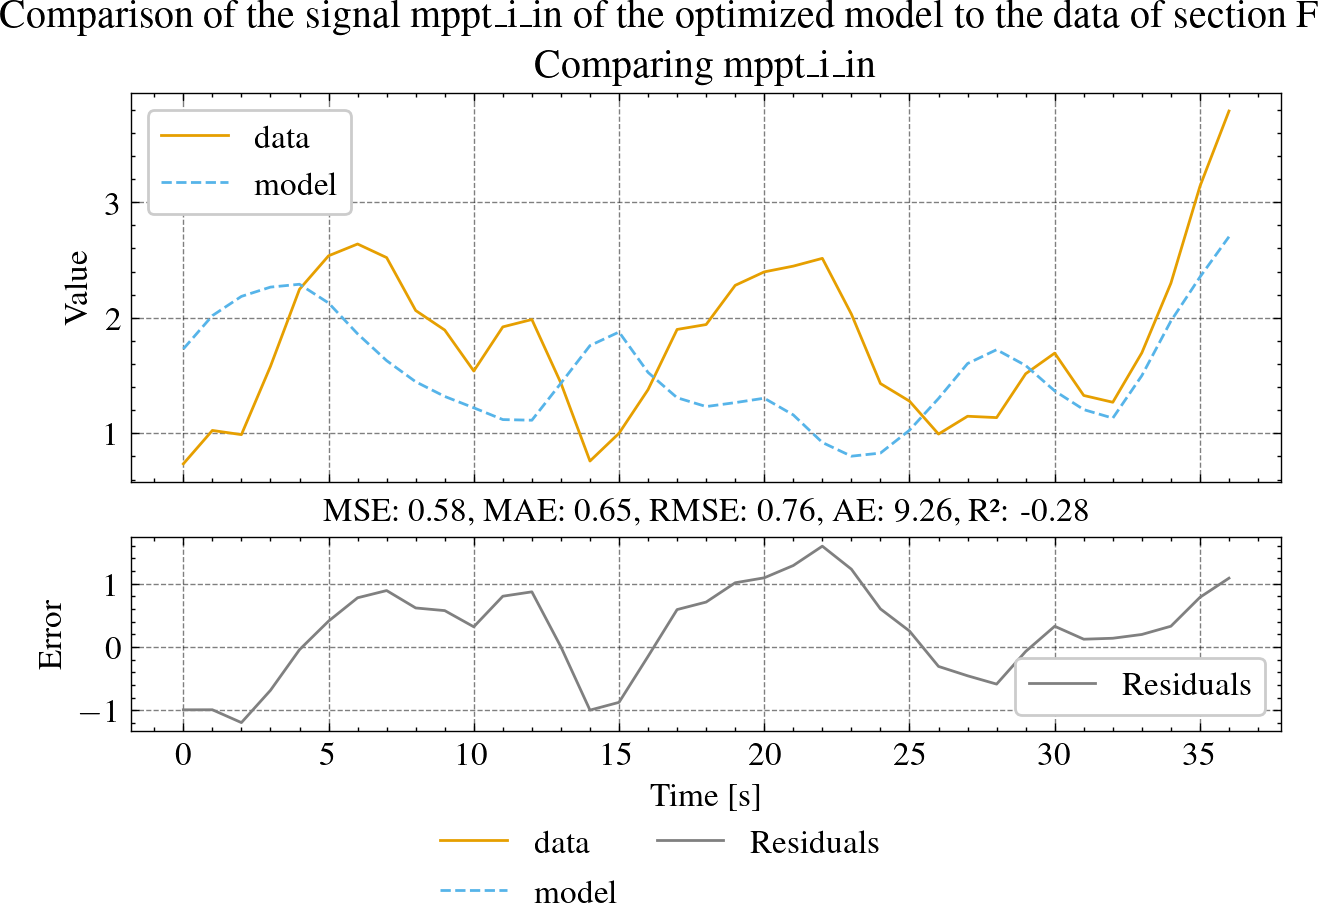

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//generation_optimization_test_residuals_mppt_v_in_test_f.pdf


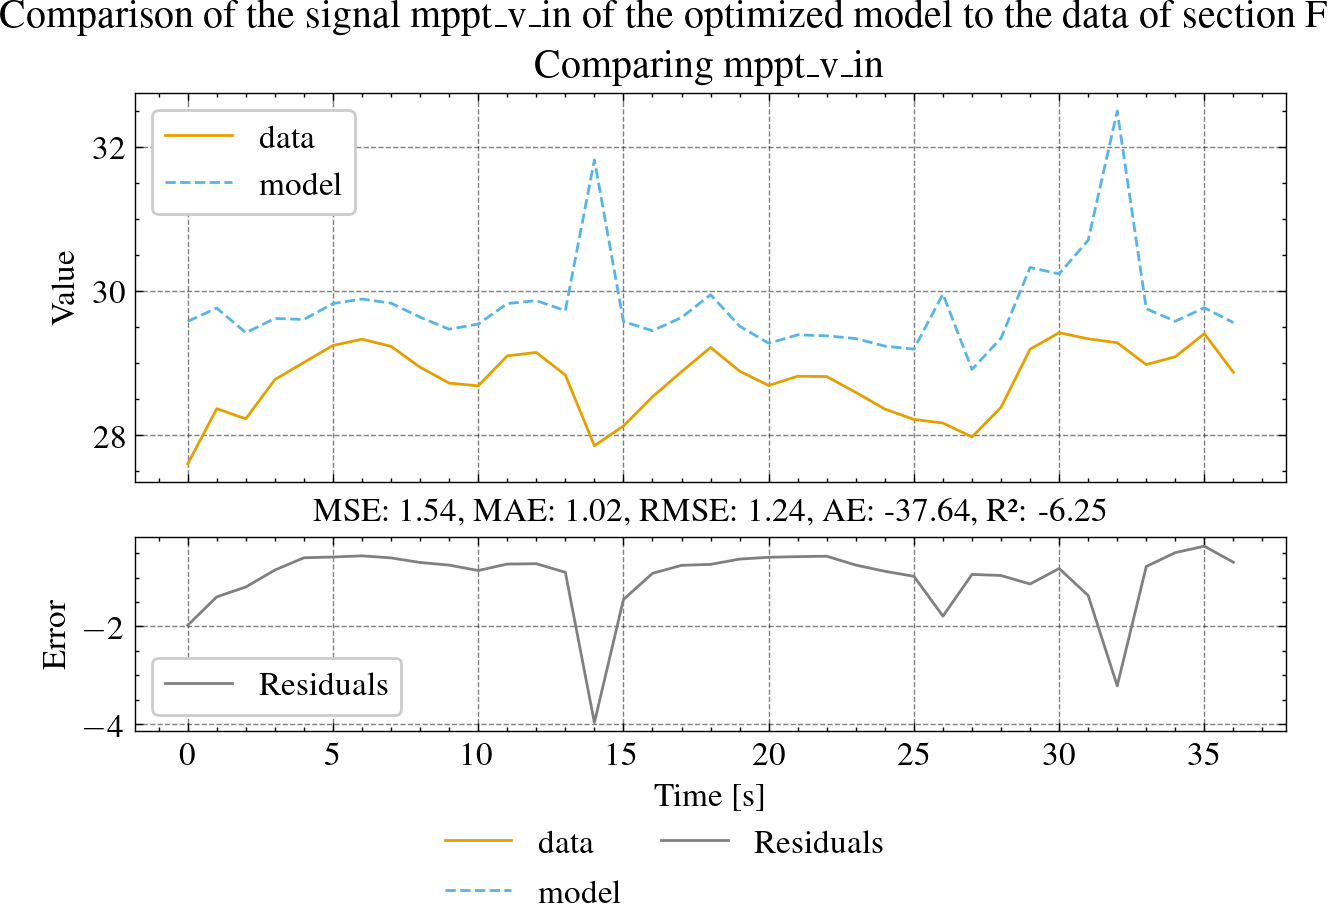

In [10]:
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

    df_pred = model_function(T, U, X0, **(model_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/generation_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )


In [11]:
# Initialize a list to store metrics
metrics_list = []
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    # Select the data and simulate
    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

    df_pred = model_function(T, U, X0, **(model_params))

    # Compute metrics for each data column
    for col in data_cols:
        metrics = compute_metrics(df_test[col].to_numpy(), df_pred[col].to_numpy())
        metrics['section'] = section_name
        metrics['data'] = col

        metrics_list.append(metrics)

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list).drop(columns=['residuals']).set_index(['section', 'data'])
display(df_metrics)

metrics_table_latex = df_metrics.to_latex(
    index=True,
    caption="Métricas de avaliação do modelo da Geração",
    label="table:generation_optimization_metrics_table",
    float_format="%.2f",
    column_format="l|l" + "|c" * (len(df_metrics.columns)),
    escape=True,
    decimal=',',
    position='h!',
    multicolumn=True,
).replace('\\toprule', '\\hline').replace('\\bottomrule\n', '').replace('\\midrule', '\\hline').replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}')

with open(f"{latex_tex_path}/generation_optimization_metrics_table.tex", "w") as f:
    f.write(metrics_table_latex)

MSE        MAE       RMSE           AE         R2
section data                                                                
A       mppt_i_in     0.343518   0.479913   0.586104    12.300487   0.724246
        mppt_v_in  2298.644419  39.004519  47.944180 -1092.126539 -44.709996
B       mppt_i_in     0.902054   0.720730   0.949765    -4.599039   0.875228
        mppt_v_in     0.635103   0.674160   0.796933   -51.348093   0.624975
D       mppt_i_in     2.416233   1.297665   1.554424     1.862641   0.535952
        mppt_v_in     0.237330   0.378016   0.487165     1.245658   0.820233
E       mppt_i_in     1.506651   0.889554   1.227457     9.045468   0.766284
        mppt_v_in     0.242433   0.403232   0.492375    -2.697868   0.425055
F       mppt_i_in     0.578417   0.648115   0.760537     9.257939  -0.277074
        mppt_v_in     1.537890   1.017406   1.240117   -37.644037  -6.250188